# Make an MTH5 from NIMS data

This notebook provides an example of how to read in NIMS (.BIN) files into an MTH5. NIMS files represent a single run.   

In [1]:
from mth5.mth5 import MTH5
from mth5.io.nims import NIMSCollection
from mth5 import read_file

2022-09-07 13:02:52,583 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


### NIMS Collection

We will use the `NIMSCollection` to assemble the *.bin* files into a logical order by run. The output NIMS files include all data for each channel for a single run. Therefore the collection is relatively simple.

*Metadata:* we need to input the `survey_id` to provide minimal metadata when making an MTH5 file. 

The `NIMSCollection.get_runs()` will return a two level ordered dictionary (`OrderedDict`).  The first level is keyed by station ID.  These objects are in turn ordered dictionaries by run ID.  Therefore you can loop over stations and runs.  

**Note**: `n_samples` and `end` are estimates based on file size not the data.  To get an accurate number you should read in the full file. 

In [2]:
nc = NIMSCollection(r"c:\Users\jpeacock\OneDrive - DOI\mt\nims")
nc.survey_id = "test"
runs = nc.get_runs(sample_rates=[8])
print(f"Found {len(runs)} station with {len(runs[list(runs.keys())[0]])} runs")

2022-09-07 13:02:53,062 [line 123] mth5.io.nims.header.NIMS.read_header - INFO: Reading NIMS file c:\Users\jpeacock\OneDrive - DOI\mt\nims\mnp300a.BIN
2022-09-07 13:02:53,081 [line 242] mth5.io.nims.header.NIMS.end_time - WARNING: Estimating end time from n_samples
2022-09-07 13:02:53,086 [line 123] mth5.io.nims.header.NIMS.read_header - INFO: Reading NIMS file c:\Users\jpeacock\OneDrive - DOI\mt\nims\mnp300b.BIN
2022-09-07 13:02:53,099 [line 242] mth5.io.nims.header.NIMS.end_time - WARNING: Estimating end time from n_samples


Found 1 station with 2 runs


In [3]:
for run_id, run_df in runs["mnp300"].items():
    display(run_df)

,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,instrument_id,calibration_fn
0,test,mnp300,mnp300a,2019-09-26 18:29:29+00:00,2019-10-01 15:03:23+00:00,1,"hx,hy,hz,ex,ey,temperature",c:\Users\jpeacock\OneDrive - DOI\mt\nims\mnp30...,8,54972155,3357078,1,NIMS,None


,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,instrument_id,calibration_fn
1,test,mnp300,mnp300b,2019-10-01 16:16:42+00:00,2019-10-03 22:55:52+00:00,1,"hx,hy,hz,ex,ey,temperature",c:\Users\jpeacock\OneDrive - DOI\mt\nims\mnp30...,8,25774314,1574003,2,NIMS,None


## Build MTH5

Now that we have a logical collection of files, lets load them into an MTH5.  We will simply loop of the stations, runs, and channels in the ordered dictionary.

There are a few things that to keep in mind:  

- The LEMI raw files come with very little metadata, so as a user you will have to manually input most of it. 
- The output files from a LEMI are already calibrated into units of nT and mV/km (I think), therefore there are no filter to apply to calibrate the data. 
- Since this is a MTH5 file version 0.2.0 the filters are in the `survey_group` so add them there.

**TODO**:

    - make sure filters get propagated throught to mth5
    - think about run names

In [4]:
calibrate = True
m = MTH5()
if calibrate:
    m.data_level = 2
m.open_mth5(nc.file_path.joinpath("from_nims.h5"))


2022-09-07 13:02:53,674 [line 663] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\mt\nims\from_nims.h5 in mode a


In [5]:
survey_group = m.add_survey(nc.survey_id)

In [6]:
%%time
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        run_ts = read_file(run_df.fn.unique()[0])
        if calibrate:
            run_ts = run_ts.calibrate()
        run_group.from_runts(run_ts)
    station_group.metadata.update(run_ts.station_metadata)
    station_group.write_metadata()
        

2022-09-07 13:02:54,234 [line 123] mth5.io.nims.header.NIMS.read_header - INFO: Reading NIMS file c:\Users\jpeacock\OneDrive - DOI\mt\nims\mnp300a.BIN
2022-09-07 13:02:54,649 [line 927] mth5.io.nims.header.NIMS.read_nims - WARNING: odd number of bytes 54971209, not even blocks cutting down the data by 72 bits
2022-09-07 13:02:55,667 [line 1019] mth5.io.nims.header.NIMS.read_nims - INFO: Reading took 1.43 seconds
2022-09-07 13:02:56,835 [line 288] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2019-10-01T15:07:08+00:00 does not match metadata end 2019-10-01T15:07:07.875000+00:00 updating metatdata value to 2019-10-01T15:07:08+00:00
2022-09-07 13:02:57,909 [line 288] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2019-10-01T15:07:08+00:00 does not match metadata end 2019-10-01T15:07:07.875000+00:00 updating metatdata value to 2019-10-01T15:07:08+00:00
2022-09-07 13:03:07,154 [line 123] mth5.io.nims.header.NIMS.read_header - IN

Wall time: 26.9 s


In [7]:
%%time
station_group.update_metadata()
survey_group.update_metadata()

Wall time: 7.68 s


#### MTH5 Structure

Have a look at the MTH5 structure and make sure it looks correct.

In [8]:
m

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: test
            --------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: dipole_101.00
                        -----------------------
                        |- Group: dipole_106.00
                        -----------------------
                        |- Group: dipole_109.00
                        -----------------------
                        |- Group: e_analog_to_digital
                        -----------------------------
                        |- Group: h_analog_to_digital
                        -----------------------------
         

### Channel Summary

Have a look at the channel summary and make sure everything looks good.

In [9]:
m.channel_summary.summarize()
m.channel_summary.to_dataframe()

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,test,mnp300,mnp300a,34.726823,-115.735015,940.0,ex,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,electric,0.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,test,mnp300,mnp300a,34.726823,-115.735015,940.0,ey,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,electric,90.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,test,mnp300,mnp300a,34.726823,-115.735015,940.0,hx,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,magnetic,0.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,test,mnp300,mnp300a,34.726823,-115.735015,940.0,hy,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,magnetic,90.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,test,mnp300,mnp300a,34.726823,-115.735015,940.0,hz,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,magnetic,0.0,90.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,test,mnp300,mnp300a,34.726823,-115.735015,940.0,temperature,2019-09-26 18:33:21+00:00,2019-10-01 15:07:08+00:00,3357016,8.0,auxiliary,0.0,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,test,mnp300,mnp300b,34.726823,-115.735015,940.0,ex,2019-10-01 16:22:01+00:00,2019-10-03 23:01:04+00:00,1573944,8.0,electric,0.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,test,mnp300,mnp300b,34.726823,-115.735015,940.0,ey,2019-10-01 16:22:01+00:00,2019-10-03 23:01:04+00:00,1573944,8.0,electric,90.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,test,mnp300,mnp300b,34.726823,-115.735015,940.0,hx,2019-10-01 16:22:01+00:00,2019-10-03 23:01:04+00:00,1573944,8.0,magnetic,0.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,test,mnp300,mnp300b,34.726823,-115.735015,940.0,hy,2019-10-01 16:22:01+00:00,2019-10-03 23:01:04+00:00,1573944,8.0,magnetic,90.0,0.0,count,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Close the MTH5

This is important, you should close the file after you are done using it.  Otherwise bad things can happen if you try to open it with another program or Python interpreter.

In [10]:
m.close_mth5()

2022-09-07 13:03:29,078 [line 744] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\mt\nims\from_nims.h5


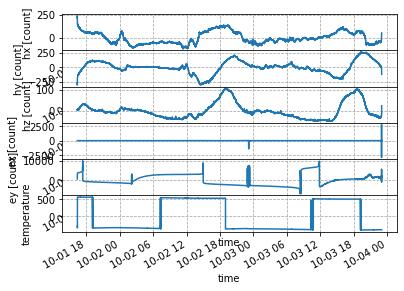

In [11]:
run_ts.plot()